In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import datetime
import time

import warnings
warnings.filterwarnings('ignore')

seed = 32

ANOMALY = False

# Load Data

In [2]:
def read_and_reformate_climatic_data(path):
    df = pd.read_excel(path, sheet_name='KELIBIA')
    df = df.drop(['NUM_STA','NOM_STA','Unnamed: 7'],axis=1)
    df.rename(columns={'DAT': 'DATE', 'Temp. Minimale °C' : 'Temp_min', 'Temp. Maximale °C':'Temp_max',
                        'Précipitation toat (mm)':'PLV', 'Evaporation Pch (mm)':'EVA'},inplace=True)
    df['DATE'] = pd.DatetimeIndex(df['DATE'])   
    df.set_index('DATE', inplace=True)
    return df

climatic_data = read_and_reformate_climatic_data('KELIBIA.xlsx')
climatic_data.head(10)

,Temp_min,Temp_max,PLV,EVA
DATE,,,,
1968-01-01,NaN,NaN,NaN,NaN
1968-01-02,NaN,NaN,NaN,NaN
1968-01-03,NaN,NaN,NaN,NaN
1968-01-04,10.0,15.5,5.1,3.9
1968-01-05,10.8,14.6,1.0,2.5
1968-01-06,12.8,16.2,NaN,3.0
1968-01-07,10.8,15.3,1.9,4.9
1968-01-08,7.4,11.9,4.2,5.6
1968-01-09,9.3,14.7,NaN,4.4


In [3]:
# Load inflow target
def read_and_reformate_inflow(file):
    #convert string french months to numeric values
    df = pd.read_excel(file, sheet_name='Sheet1')
    df.rename(columns={'apport':'APP'},inplace=True)
    dates = df.pop('date')
    dates = dates.str.split(' ')
    months_names = ['Janvier','Février','Mars','Avril','Mai','Juin','Juillet','Aôut','Septembre','Octobre','Novembre','Décembre']
    months_values = ['01/01','02/01','03/01','04/01','05/01','06/01','07/01','08/01','09/01','10/01','11/01','12/01']
    data_date_format = []
    for date in dates:
        index = months_names.index(date[0])
        data_date_format.append(months_values[index]+'/'+date[1])
    df['date']= pd.DatetimeIndex(data_date_format)  
    df.set_index('date', inplace=True)
    return df

inflow = read_and_reformate_inflow('apport.xlsx')
inflow.head(10)

,APP
date,
1986-08-01,0.000
1986-09-01,0.000
1986-10-01,0.200
1986-11-01,5.580
1986-12-01,1.550
1987-01-01,5.865
1987-02-01,8.217
1987-03-01,2.130
1987-04-01,0.856


# Visualize Time Series

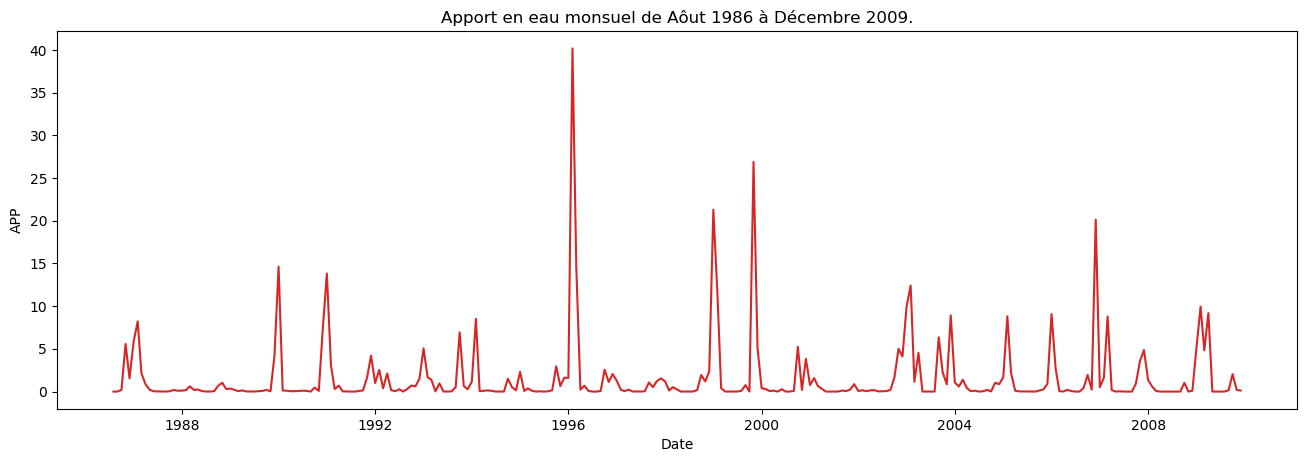

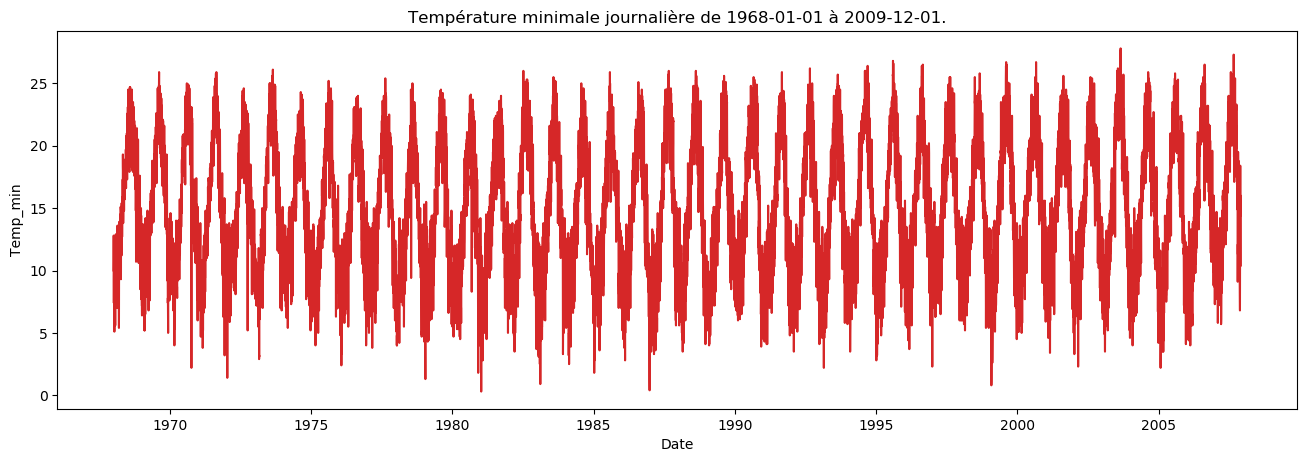

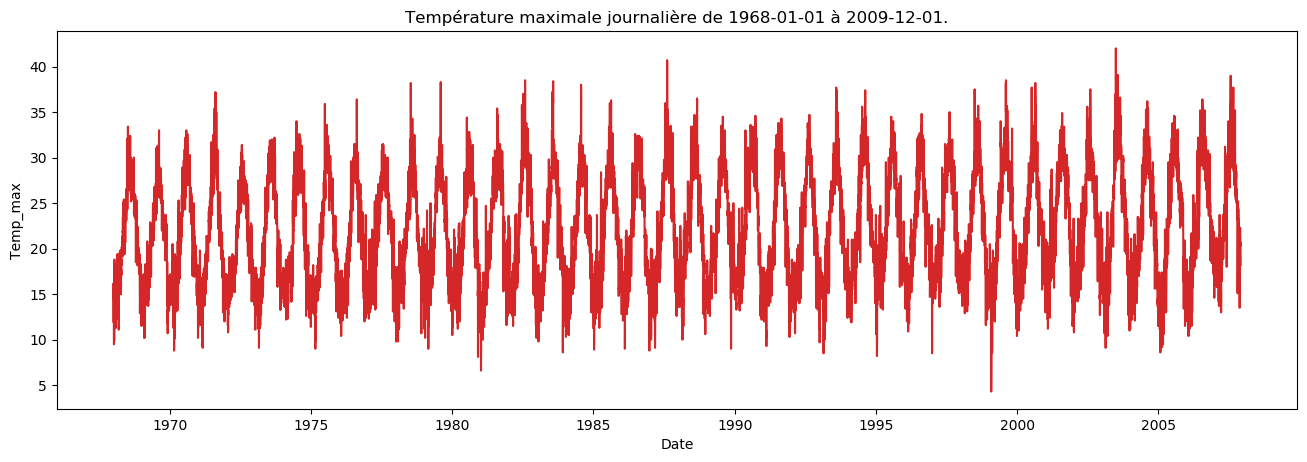

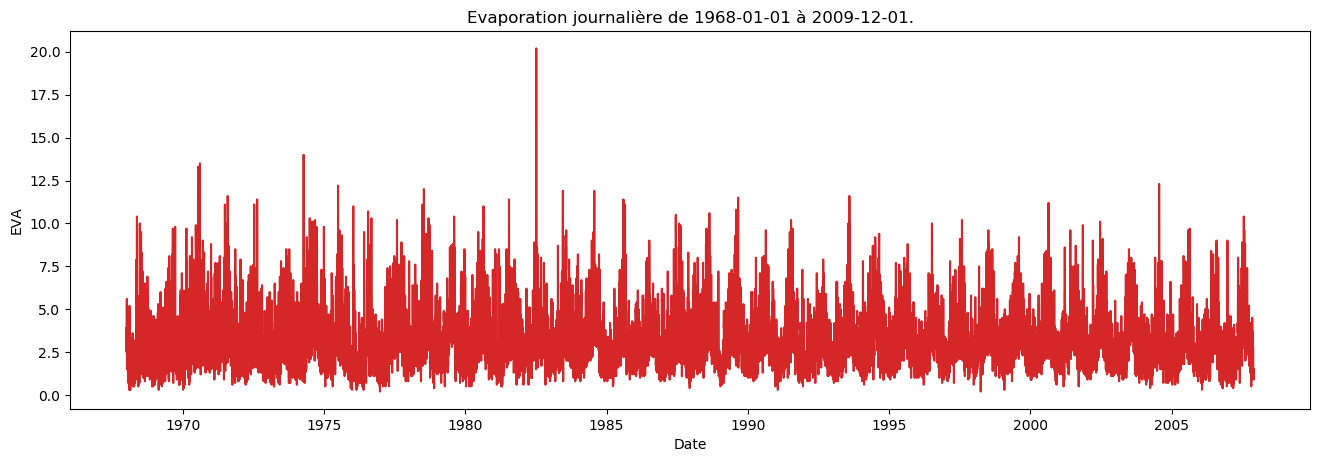

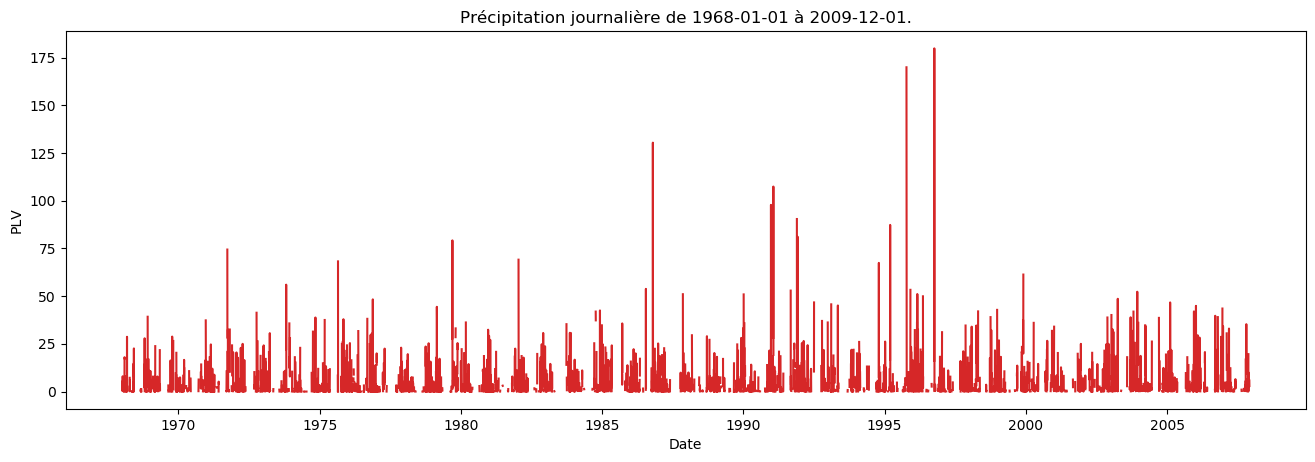

In [4]:
def plot_ts(df, x, y, title="", xlabel='Date', ylabel="", dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
# Inflow
plot_ts(inflow, x=inflow.index, y=inflow.APP, ylabel='APP', title='Apport en eau monsuel de Aôut 1986 à Décembre 2009.') 
# Temp_min
plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.Temp_min, ylabel='Temp_min', title='Température minimale journalière de 1968-01-01 à 2009-12-01.') 
# Temp_max
plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.Temp_max, ylabel='Temp_max', title='Température maximale journalière de 1968-01-01 à 2009-12-01.') 
# EVA
plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.EVA, ylabel='EVA', title='Evaporation journalière de 1968-01-01 à 2009-12-01.') 
# PLV
plot_ts(climatic_data, x=climatic_data.index, y=climatic_data.PLV, ylabel='PLV', title='Précipitation journalière de 1968-01-01 à 2009-12-01.') 

# Data Preprocessing

In [5]:
def preprocessing(original_data):
    clean_data = original_data.copy()
    clean_data.drop_duplicates(keep='first', inplace=True)
    ### fill missing data 
    clean_data.interpolate(inplace=True)
    clean_data.fillna(method='bfill',inplace=True)    
    print('missing values:',clean_data.isna().sum().sum())
    return clean_data

climatic_data_cleaned = preprocessing(climatic_data)
climatic_data_cleaned.describe()

missing values: 0


,Temp_min,Temp_max,PLV,EVA
count,14486.000000,14486.000000,14486.000000,14486.000000
mean,14.723074,21.933708,3.979963,3.230198
std,5.368400,5.821237,7.265715,1.746959
min,0.300000,4.300000,0.000000,0.200000
25%,10.200000,17.000000,0.400000,2.000000
50%,14.300000,21.300000,1.450000,2.900000
75%,19.300000,27.000000,4.459935,4.100000
max,27.800000,42.000000,179.800000,20.200000


# Split Into 4 Seasonal Datasets

In [6]:
saisons = ['Automne', 'Hiver', 'Printemps', 'Eté']

def create_seasonal_data(full_data):
    data = [pd.DataFrame() for i in range(4)]     
    month = pd.DatetimeIndex(full_data.index).month
    #Autumn
    data[0] = full_data[np.logical_or(month==9,np.logical_or(month==10,month==11))] 
    #Winter
    data[1] = full_data[np.logical_or(month==12,np.logical_or(month==1, month==2))]   
    #Spring
    data[2] = full_data[np.logical_or(month==3,np.logical_or(month==4, month==5))]
    #Summer
    data[3] = full_data[np.logical_or(month==6,np.logical_or(month==7, month==8))] 
    return data

seasonal_data = create_seasonal_data(climatic_data_cleaned)

# Anomaly Detection

### 1- split train & test data

In [7]:
# split data into train & test sets
from sklearn.model_selection import train_test_split
train_seasonal_data = []
for index , subset_elem in enumerate(seasonal_data):
    data_train, data_test = train_test_split(subset_elem, test_size=0.15, random_state=seed, shuffle=True)
    train_seasonal_data.append(data_train)

### 6. Anomaly Detection & Filtering

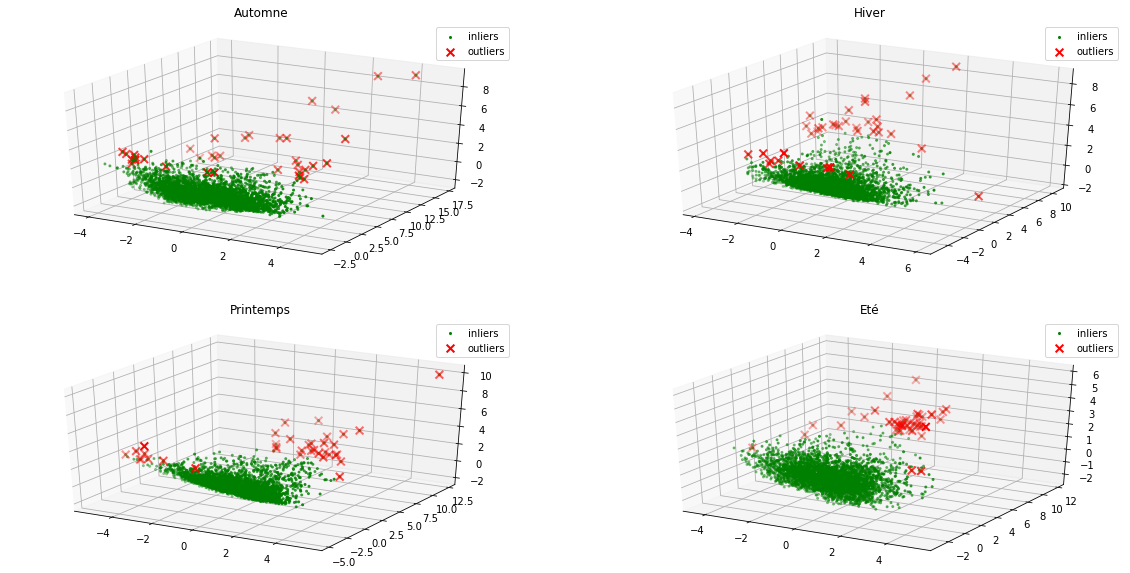

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

from mpl_toolkits.mplot3d import Axes3D


IForest=IsolationForest(n_estimators=100,max_samples='auto',contamination=0.01,max_features=1.0,bootstrap=True, n_jobs=-1, random_state=42, verbose=0)
DB = DBSCAN(eps =0.6, metric='euclidean', min_samples=3, n_jobs=-1)
LOF = LocalOutlierFactor(n_neighbors=5, contamination=0.01)

def build_detecor(data, detector):
    #scaling
    scaler = StandardScaler().fit(data)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    # PCA dimensionality reduction
    pca = PCA(n_components=3).fit(data) # !!! scaled training data
    data = pd.DataFrame(pca.transform(data), index=data.index, columns = ['PC1', 'PC2', 'PC3'])
    # anomaly detector
    detector = detector.fit(data)
    return scaler, pca, detector

def anomaly_detection(data, scaler, pca, detector):
    transformed_data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    transformed_data = pd.DataFrame(pca.transform(transformed_data), index=transformed_data.index, columns = ['PC1', 'PC2', 'PC3'])
    pred  = detector.predict(transformed_data)
    data['anomaly'] = pred
    outliers = list(data[data['anomaly']==-1].index)    
    return transformed_data, data, outliers

def filter_outlier(X, outliers):
    X.loc[outliers, :] = np.nan
    X.interpolate(inplace=True)
    X.fillna(method='bfill',inplace=True)    
    return X

fig = plt.figure(figsize=(20,10))

outliers = [None] * 4

for index , subset_elem in enumerate(train_seasonal_data):
    
    ax = fig.add_subplot(2, 2, index+1, projection='3d')
    
    # build anomay detector
    scaler, pca, detector = build_detecor(subset_elem, IForest)
    
    # anomaly detection
    transformed_data, seasonal_data[index], outliers[index] = anomaly_detection(seasonal_data[index], scaler, pca, detector)
    
    # Plot the compressed data points
    ax.scatter(transformed_data.loc[:,'PC1'], transformed_data.loc[:,'PC2'], zs=transformed_data.loc[:,'PC3'], s=4, lw=1, label="inliers",c="green")
    ax.scatter(transformed_data.loc[outliers[index],'PC1'],transformed_data.loc[outliers[index],'PC2'],transformed_data.loc[outliers[index],'PC3'],lw=2, s=60, marker="x", c="red", label="outliers")
    ax.title.set_text(saisons[index])
    ax.legend()    
    
    # filter anomalies
    seasonal_data[index] = filter_outlier(seasonal_data[index], outliers[index])    
    
plt.show()
    

Detected anomalies for season: Automne


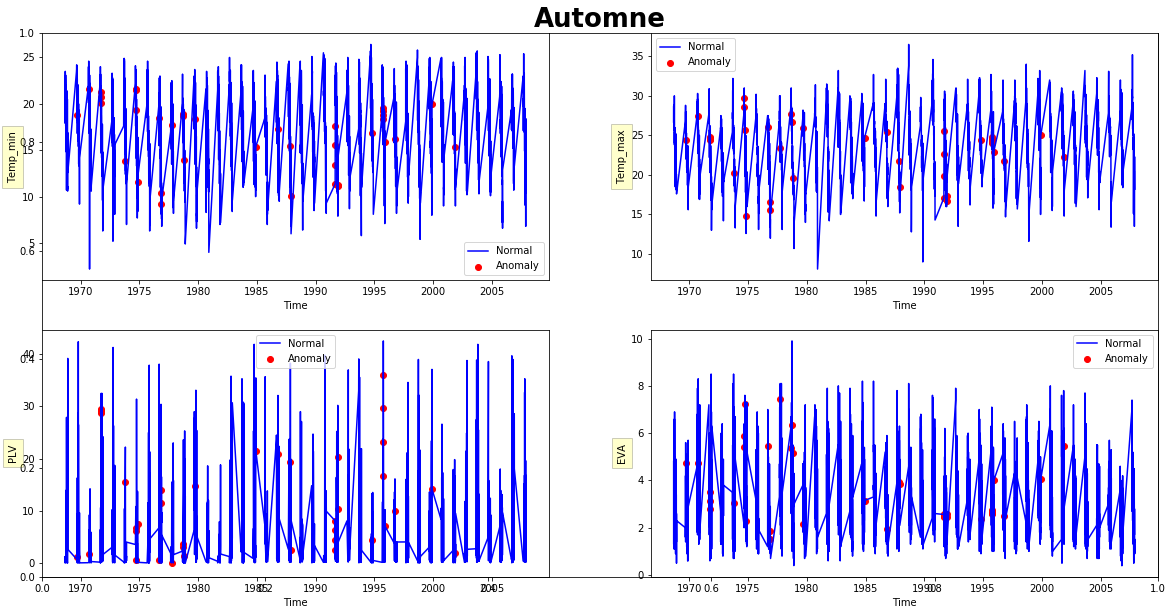

Detected anomalies for season: Hiver


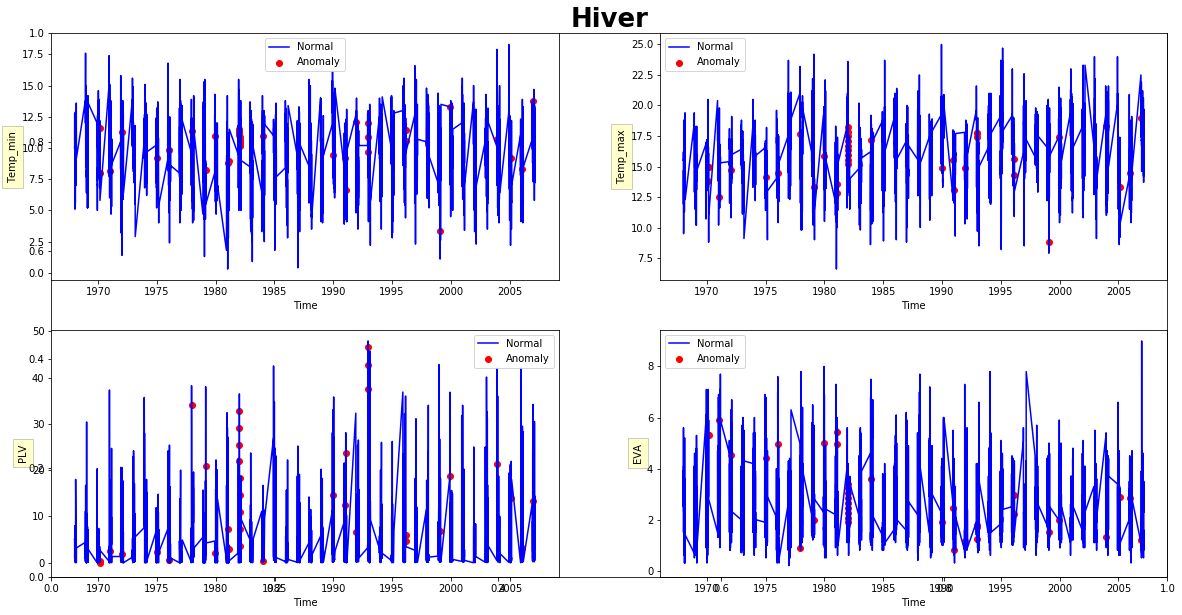

Detected anomalies for season: Printemps


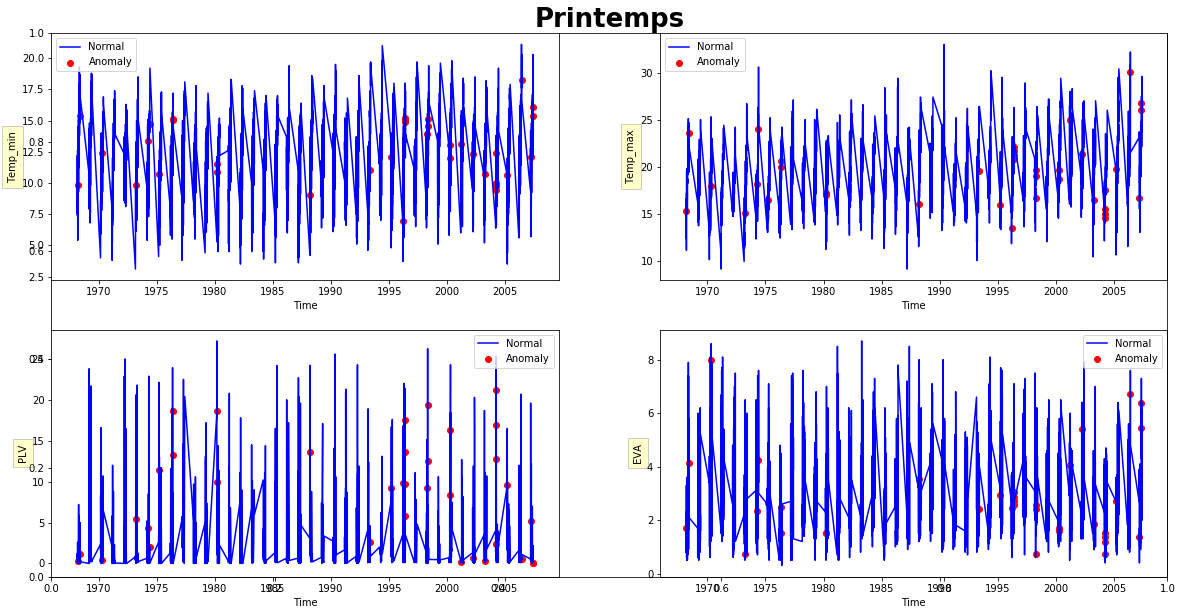

Detected anomalies for season: Eté


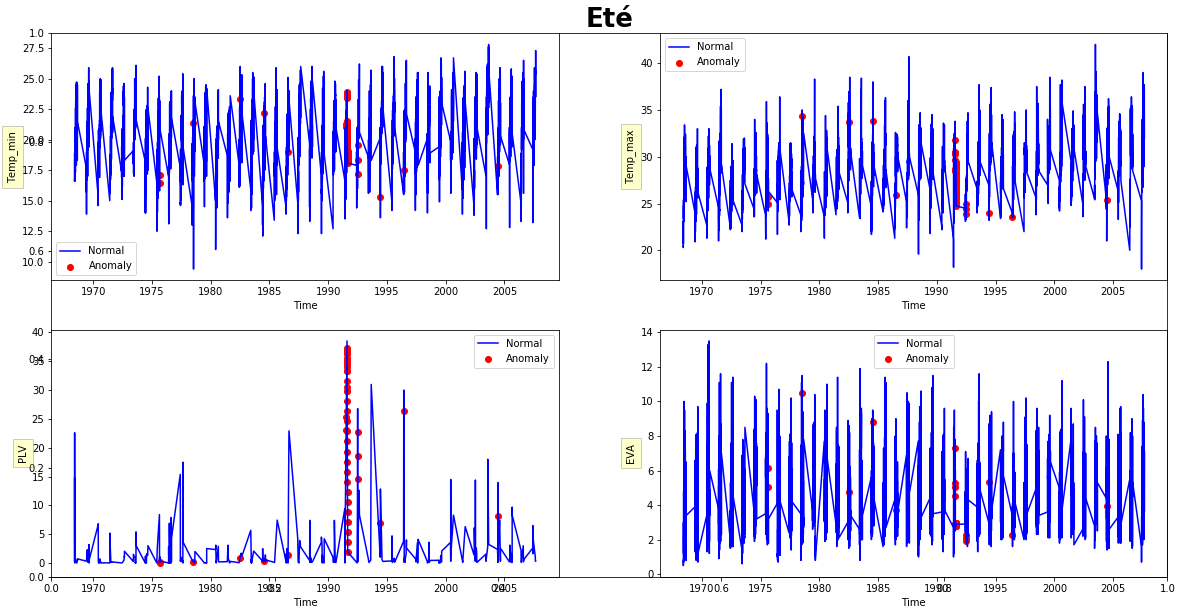

In [9]:
def plot_anomalies(df, outliers, saison):
        
    fig = plt.figure(figsize=(20,10))
    plt.title(saison,fontsize=26, fontweight='bold')
    box = dict(facecolor='yellow', pad=5, alpha=0.2)  
    
    #Temp_min
    ax = fig.add_subplot(2, 2, 1)
    a = df.loc[outliers, ['Temp_min']] #anomaly
    ax.plot(df.index, df['Temp_min'], color='blue', label='Normal')
    ax.scatter(a.index,a['Temp_min'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Temp_min', bbox=box)
    plt.legend()    
        
    #Temp_max
    ax = fig.add_subplot(2, 2, 2)
    a = df.loc[outliers, ['Temp_max']] #anomaly
    ax.plot(df.index, df['Temp_max'], color='blue', label='Normal')
    ax.scatter(a.index,a['Temp_max'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('Temp_max', bbox=box)
    plt.legend()
    
    #PLV
    ax = fig.add_subplot(2, 2, 3)
    a = df.loc[outliers, ['PLV']] #anomaly
    ax.plot(df.index, df['PLV'], color='blue', label='Normal')
    ax.scatter(a.index,a['PLV'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('PLV', bbox=box)
    plt.legend()
    
    #EVA
    ax = fig.add_subplot(2, 2, 4)
    a = df.loc[outliers, ['EVA']] #anomaly
    ax.plot(df.index, df['EVA'], color='blue', label='Normal')
    ax.scatter(a.index,a['EVA'], color='red', label='Anomaly')
    plt.xlabel('Time')
    plt.ylabel('EVA', bbox=box)
    plt.legend()
    plt.show()
    
for i in range(4):
    print('Detected anomalies for season:', saisons[i])
    plot_anomalies(seasonal_data[i].sort_index(), outliers[i], saisons[i])


In [10]:
## concatunate cleaned seasonal data
if(ANOMALY):
    climatic_data_cleaned = pd.concat(seasonal_data)
    climatic_data_cleaned = climatic_data_cleaned.sort_index()

In [11]:
climatic_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14486 entries, 1968-01-01 to 2007-11-30
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Temp_min  14486 non-null  float64
 1   Temp_max  14486 non-null  float64
 2   PLV       14486 non-null  float64
 3   EVA       14486 non-null  float64
dtypes: float64(4)
memory usage: 565.9 KB


# Concatunate climatic data & inflow

In [12]:
from sklearn.model_selection import train_test_split
def concatunate_inflow(data_cleaned, inflow): 
    data = data_cleaned.copy()
    data['APP'] = np.nan
    for year in sorted(pd.unique(pd.DatetimeIndex(inflow.index).year)):
        for month in range(1,13):
            index_app = list(inflow[np.logical_and(year==pd.DatetimeIndex(inflow.index).year, 
                                                   month==pd.DatetimeIndex(inflow.index).month)].index)
            index_data = list(data[np.logical_and(year==pd.DatetimeIndex(data.index).year, 
                                               month==pd.DatetimeIndex(data.index).month)].index)
            if len(index_data)>0 and len(index_app)>0:
                data.loc[index_data, 'APP'] = inflow.loc[index_app, 'APP'].values[0]   
    data.dropna(axis=0,inplace=True)
    return data

data_inflow = concatunate_inflow(climatic_data_cleaned, inflow)
data_inflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7719 entries, 1986-08-01 to 2007-11-30
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Temp_min  7719 non-null   float64
 1   Temp_max  7719 non-null   float64
 2   PLV       7719 non-null   float64
 3   EVA       7719 non-null   float64
 4   APP       7719 non-null   float64
dtypes: float64(5)
memory usage: 361.8 KB


# Time Series Feature Engineering 

# concat seasonal_X[i]
all_seasonal_X = pd.concat(seasonal_X)
all_seasonal_data = pd.concat(seasonal_data)

print(all_seasonal_X.info())
print(all_seasonal_data.info())

#drop monthly series with nan inflow
X_clean = all_seasonal_X.loc[all_seasonal_data['APP'].notna()]
X_clean['APP'] = all_seasonal_data.loc[X_clean.index, 'APP']

# prepare test dataset
print('Missing values in test dataset:', data_test.isna().sum().sum())
X_comp_test['APP'] = data_test['APP']
X_comp_test.head()

clean_data_inflow = data_inflow.dropna(axis=0, inplace=False)
clean_data = clean_data_inflow.drop('APP', axis=1)
clean_data = pd.DataFrame(StandardScaler().fit_transform(clean_data), index=clean_data_inflow.index,
                          columns = clean_data.columns)
clean_data['APP'] = clean_data_inflow['APP'] 

In [13]:
from tsfresh import extract_features, extract_relevant_features
from tsfresh.feature_extraction import EfficientFCParameters, ComprehensiveFCParameters, MinimalFCParameters

extraction_settings = MinimalFCParameters()

def feature_extraction(df, method='describe'):   
    # Prepare time series : each monthly time serie has an ID and Time in range (0, length(serie))
    data = df.copy()
    data['ID'] = None
    data['Time'] = None
    ID = 1  
    ts_date = []
    for month in range(1,13): 
        for year in pd.unique(pd.DatetimeIndex(data.index).year):                   
            Serie_index = list(data[np.logical_and(year==pd.DatetimeIndex(df.index).year, 
                                        month==pd.DatetimeIndex(df.index).month)].index)
            if len(Serie_index)>0:
                time = list(range(0, len(Serie_index)))
                data.loc[Serie_index, 'ID'] = ID
                data.loc[Serie_index, 'Time'] = time
                ts_date.append(Serie_index[0])
                ID = ID+1  
                
    target = pd.Series(data.loc[data['Time']==0,'APP'].values, index=range(1,data['ID'].max()+1))
   
    if(method=='tsfresh'):
        features = extract_relevant_features(data.drop('APP', axis=1), target, column_id='ID', column_sort='Time',
                                             default_fc_parameters=extraction_settings)
    else:
        features = data.drop(['APP','Time'], axis=1).groupby(['ID']).describe() 
        #features.drop([('PC1', 'count'), ('PC2', 'count'), ('PC3', 'count')], axis=1, inplace= True)
        features.drop([('Temp_min', 'count'), ('Temp_max', 'count'), ('PLV', 'count'), ('EVA', 'count')], axis=1, inplace= True)
    
    features['DATE'] = ts_date
    features.set_index('DATE', inplace=True)        
    return features, target

ts_features, ts_targets = feature_extraction(data_inflow)

In [14]:
names = []
for i in range(len(ts_features.columns)):
    names.append('F'+str(i))

ts_features= pd.DataFrame(ts_features.values, columns=names, index=ts_features.index)
ts_features.sort_index(inplace=True)

In [15]:
ts_features_targets = ts_features.copy()
ts_features_targets['APP'] = ts_targets.values
ts_features_targets.sort_index(inplace=True)

# Split & Scaling & Transformation

In [16]:
# split data into train & test sets
from sklearn.model_selection import train_test_split
X = ts_features_targets.drop('APP', axis=1)
y = ts_features_targets[['APP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed, shuffle=True)

In [17]:
# scaling and transform data
from sklearn.preprocessing import PowerTransformer, StandardScaler
def data_scaling_transform(X_train, X_test, y_train, y_test):
    ### transform input variables
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    ### transform target variables
    transformer = PowerTransformer().fit(y_train)
    y_train = transformer.transform(y_train)
    y_test = transformer.transform(y_test)     
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_scaling_transform(X_train, X_test, y_train, y_test)

In [18]:
X_train.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
DATE,,,,,,,,,,,,,,,,,,,,,
1988-02-01,-1.391008,0.488755,-1.312391,-1.499462,-1.346074,-1.284070,-1.511961,-1.243385,0.300520,-1.360577,...,-0.352011,-0.383908,-0.604470,-0.407786,0.497600,-0.326897,-0.588257,-0.761636,-0.878624,0.691315
1999-08-02,1.794931,-0.907072,1.789884,1.866200,1.783192,1.770741,1.570422,1.793819,0.761951,1.689612,...,-0.641913,-0.807791,-0.807384,1.259170,0.883985,1.450966,1.323175,1.096516,0.984983,1.456699
1996-06-01,0.608521,-1.064042,0.943809,0.613861,0.547431,0.490342,0.668773,0.584524,0.035098,0.656484,...,1.392302,2.406563,0.423810,0.287069,0.320869,0.206462,0.303745,0.443652,0.186295,0.334135
2005-11-01,-0.315352,3.412385,-0.729539,-0.423233,-0.349492,0.006412,0.375212,-0.318494,3.000852,-0.803016,...,0.405818,0.311078,-0.353570,-0.755213,-0.849334,-0.326897,-0.460828,-0.661196,-0.960540,-0.533300
1990-06-01,0.830837,-0.217790,0.417362,1.010109,0.896235,0.752471,0.836521,0.748734,0.016581,0.640085,...,-0.529418,-0.818589,-0.850670,0.674798,0.264446,1.273180,0.399316,0.895635,0.493483,0.385161


# Modeling 

In [19]:
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(HuberRegressor())
    models.append(Ridge())
    models.append(Lasso(max_iter=1500))
    models.append(KNeighborsRegressor(n_neighbors=3))
    models.append(SVR())
    models.append(DecisionTreeRegressor())
    models.append(ExtraTreeRegressor())
    models.append(BaggingRegressor(base_estimator=DecisionTreeRegressor()))
    models.append(RandomForestRegressor())
    models.append(ExtraTreesRegressor())
    models.append(AdaBoostRegressor(random_state=seed))
    models.append(GradientBoostingRegressor(random_state=seed))
    models.append(XGBRegressor(objective ='reg:squarederror'))
    models.append(MLPRegressor())
    return models

def train_test_models(X_train, y_train, X_test, y_test):
    result = pd.DataFrame()
    shuffle = KFold(n_splits=10, shuffle=True, random_state=seed)
    models = get_models()
    for index, model in enumerate(models):
        scores = cross_validate(model, X_train, y_train, cv=shuffle, scoring='r2',return_estimator=True)
        # index of best score
        pos_max = np.argmax(scores['test_score'])
        y_pred = scores['estimator'][pos_max].predict(X_test)
        r2 = r2_score(y_test, y_pred)
        models[index] = scores['estimator'][pos_max] 
        result = result.append(pd.DataFrame([[model.__class__.__name__, r2]], columns=['Models','R2']))
    return models, result 

models, result  = train_test_models(X_train, y_train, X_test, y_test)
print(result)

                      Models        R2
0           LinearRegression  0.694532
0             HuberRegressor  0.701655
0                      Ridge  0.702104
0                      Lasso -0.043380
0        KNeighborsRegressor  0.644220
0                        SVR  0.830112
0      DecisionTreeRegressor  0.543927
0         ExtraTreeRegressor  0.337585
0           BaggingRegressor  0.781681
0      RandomForestRegressor  0.852090
0        ExtraTreesRegressor  0.830167
0          AdaBoostRegressor  0.786902
0  GradientBoostingRegressor  0.873633
0               XGBRegressor  0.850021
0               MLPRegressor  0.824217
